In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm

import io
from PIL import Image



# %pylab inline

import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from pathlib import Path, PurePath

from collections import deque


import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
plt.rcParams['figure.figsize'] = [640/50., 480 /50.]

In [3]:
def crop_image(bgr_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]

    return sm_image

    
def bgr_flow_frame_to_vector_flow(bgr_frame):
    
    hsv = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2HSV)
    
    mag = hsv[...,2]
    angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here
    
    u = np.cos(angle) * mag * -1 # this is the same as flow[...,0] * mag * -1, as I did above
    v = np.sin(angle) * mag
    
#     mag = np.array(mag).astype(np.float64)
#     angle = np.array(angle).astype(np.float64)    
#     u, v = cv2.polarToCart(mag, angle, angleInDegrees = True)
    
     
    flow = np.zeros([np.shape(bgr_frame)[0],np.shape(bgr_frame)[1],2])

    flow[...,0] = u
    flow[...,1] = v
    
    return flow
        

In [38]:

def plot_flow_overlay(image_in, flow_in, crop_to=0.8, skippts=5,scale=20, scale_units = 'width',width=.008, return_image = False):
    
    dpi = 100
    fig, ax = plt.subplots()
    #plt.subplots(figsize=(np.shape(image_in)[1] / dpi, np.shape(image_in)[0] / dpi))
    canvas = FigureCanvas(fig)
    ax.margins(0)

    if crop_to:
        image_in = crop_image(image_in,crop_to)
        flow_in = crop_image(flow_in,crop_to)
    
    s = slice(None,None,skippts)
    
    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    x = x[s]
    y = y[s]
    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = flow_in[...,0]
    v = flow_in[...,1]
    
    u = (u[s,s]/255) * scale
    v = (v[s,s]/255) * scale

    mag = np.sqrt(u**2 + v**2)
    xs, ys = np.where( mag > 1)

    plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax.axis('off') 
    
    plt.quiver(x2d[xs,ys],y2d[xs,ys],u[xs,ys],v[xs,ys],color='white', alpha=0.7, width=width,scale = scale,
                  scale_units = 'inches')
    
#     if skippts:
#         skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy
#         plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white', alpha=0.7, width=width,scale = scale,
#                   scale_units = 'inches')
#     else:
#         plt.quiver(x2d,y2d, u, v, color='white',alpha=0.5)
    
    if return_image:
        
        canvas.draw()  # draw the canvas, cache the renderer
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,)) 
        return image_from_plot
    

In [5]:
   
def visualize_flow_as_vectors(frame, flow, divisor=15, crop_to = 1.0,thickness = 2, tipLength = 0.35, scale = 1):

        '''Display image with a visualisation of a flow over the top.
        A divisor controls the density of the quiver plot.'''

        # create a blank mask, on which lines will be drawn.
        mask = np.zeros([np.shape(frame)[0], np.shape(frame)[1], 3], np.uint8)
        
        if crop_to:
            frame = crop_image(frame,crop_to)
            flow = crop_image(flow,crop_to)
        
        u = flow[...,0] # height
        v = -flow[...,1] # width
    
        for r in range(0, int(np.shape(flow)[0] / divisor)): # iterate through height
            for c in range(0, int(np.shape(flow)[1] / divisor)): # iterate through width
                
                origin_x = c * divisor
                origin_y = r * divisor

                endpoint_x = origin_x + int(u[origin_y, origin_x] * scale)
                endpoint_y = origin_y + int(v[origin_y, origin_x] * scale)

                mask = cv2.arrowedLine(mask, (origin_x, origin_y), (endpoint_x, endpoint_y), color=(255, 255, 255 ), 
                                       thickness = thickness, tipLength = tipLength)

        return cv2.addWeighted(frame, 0.5, mask, 0.5, 0)

In [6]:
#hsv_video_path = r'D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\exports\000\world_nvidia2_gaze-centered_hsv.mp4'
hsv_video_path = r'D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\exports\000\world_nvidia2_hsv_overlay.mp4'

#hsv_video_path =  r'D:\Github\retinal_flow_toolkit\flow_out\linear_travel\linear_travel_nvidia2_hsv_overlay.mp4'

hsv_video = cv2.VideoCapture(hsv_video_path)

# number of frames in the video
length = int(hsv_video.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )


14428


In [7]:
world_video_path = r'D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\world.mp4'
#world_video_path = r'D:\Github\retinal_flow_toolkit\demo_input_video\linear_travel.mp4'

world_video = cv2.VideoCapture(world_video_path)

# number of frames in the video
length = int(world_video.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )



14428


## Single image

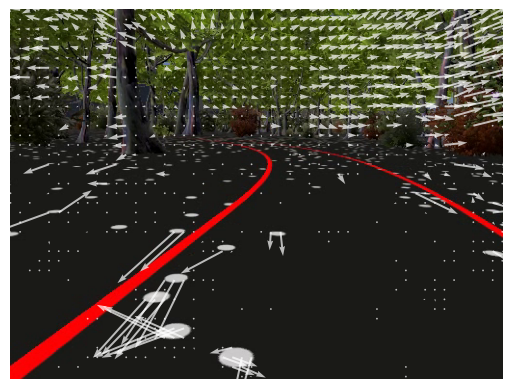

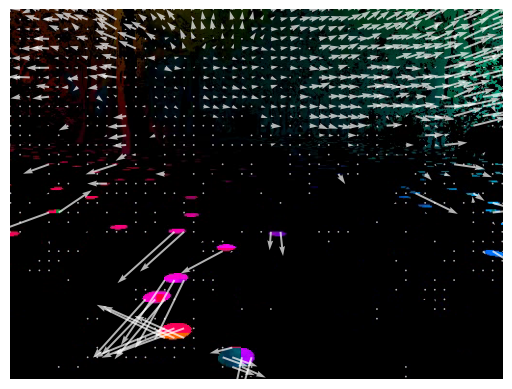

In [8]:
w_f = 7800-6
f_f = 7800

# w_f = 10800 -5
# f_f = 10800

plt.rcParams['figure.figsize'] = [640/100., 480 /100.]

world_video.set(cv2.CAP_PROP_POS_FRAMES, w_f)
world_success, bgr_world = world_video.read()

hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f_f)
flow_success, bgr_flow = hsv_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)

plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)

####
hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f_f)
flow_success, bgr_flow = hsv_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)
plot_flow_overlay(bgr_flow, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)

In [9]:
world_video.set(cv2.CAP_PROP_FPS,29.852)

False

In [10]:
#world_video.get(cv2.CAP_PROP_FOURCC) 
#world_video.get(cv2.CAP_PROP_POS_MSEC) # CAP_PROP_FPS 
world_video.get(cv2.CAP_PROP_FPS) # 29.852196518048217
#world_video.get(cv2.CAP_PROP_POS_AVI_RATIO) #

29.852196518048217

In [11]:
hsv_video.get(cv2.CAP_PROP_FOURCC) 
#hsv_video.get(cv2.CAP_PROP_POS_MSEC) # cv2.CAP_PROP_POS_MSEC
#hsv_video.get(cv2.CAP_PROP_FPS) # 29.852
#hsv_video.get(cv2.CAP_PROP_POS_AVI_RATIO) #


1983148141.0

## Single vector overlay

In [12]:
# matplotlib.use('Qt5Agg')

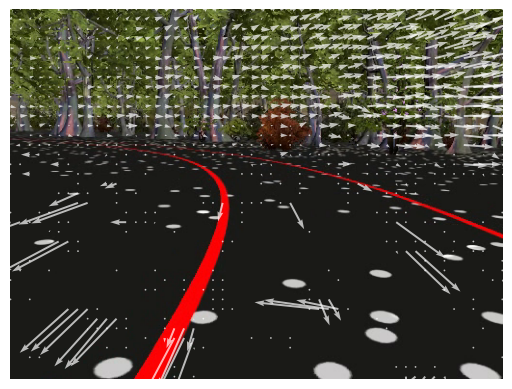

In [13]:
f = 10800
#f = 20


world_video.set(cv2.CAP_PROP_POS_FRAMES, f)
world_success, bgr_world = world_video.read()

hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f)
flow_success, bgr_flow = hsv_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)
# plt.imshow(cv2.cvtColor(bgr_world, cv2.COLOR_BGR2RGB))


plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)
# plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)

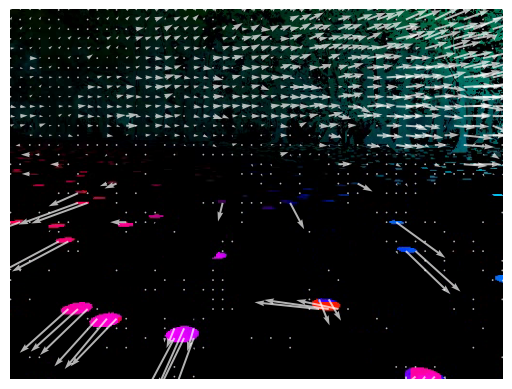

In [14]:
f = 10800
#f = 20


world_video.set(cv2.CAP_PROP_POS_FRAMES, f)
world_success, bgr_world = world_video.read()

hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f)
flow_success, bgr_flow = hsv_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)
# plt.imshow(cv2.cvtColor(bgr_world, cv2.COLOR_BGR2RGB))

plot_flow_overlay(bgr_flow, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)
# plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)

(-0.5, 511.5, 383.5, -0.5)

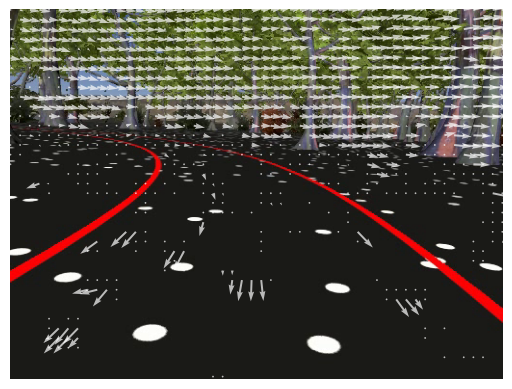

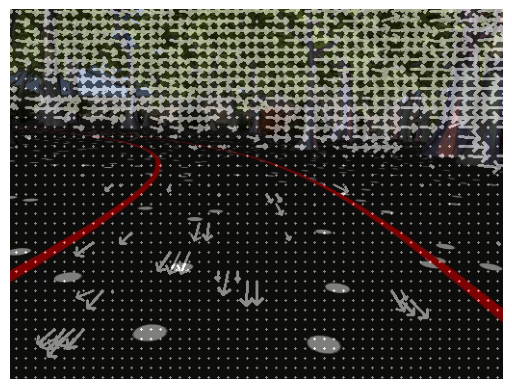

In [15]:
f = 10840
#f = 10

world_video.set(cv2.CAP_PROP_POS_FRAMES, f)
world_success, bgr_world = world_video.read()

hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f)
flow_success, bgr_flow = hsv_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)

plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)


flow_im = visualize_flow_as_vectors(bgr_world, flow, 
                                    divisor=10, 
                                    crop_to = 1.0,
                                    thickness = 2, 
                                    tipLength = 0.35,
                                    scale = .1)

flow_im = crop_image(flow_im,0.8)

fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(flow_im, cv2.COLOR_BGR2RGB))
ax.axis('off') 

## Single overlay sequence

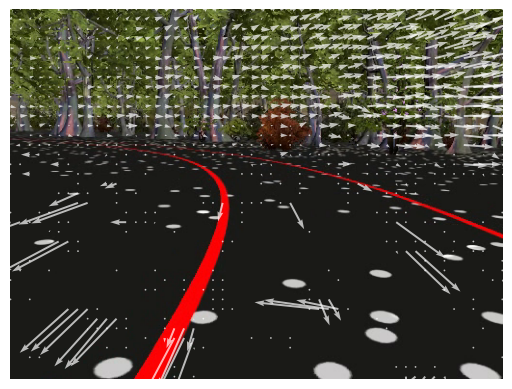

In [16]:
f = 10800
#f = 10

world_video.set(cv2.CAP_PROP_POS_FRAMES, f)
world_success, bgr_world = world_video.read()

hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f)
flow_success, bgr_flow = hsv_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)
# plt.imshow(cv2.cvtColor(bgr_world, cv2.COLOR_BGR2RGB))

plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)

In [118]:
f = 10800
#f = 1


buffer_len = 10
start_frame = f
end_frame = start_frame + buffer_len*10

world_video.set(cv2.CAP_PROP_POS_FRAMES, f)
hsv_video.set(cv2.CAP_PROP_POS_FRAMES, f)

plt.rcParams['figure.figsize'] = [640/40., 480/40.]


flow_fr_y_x_uv = []

flow_buffer = deque([] * buffer_len)
div_time = []

cv2.destroyAllWindows()

frame_num = f

world_success = True
while world_success:
    
    world_success, bgr_world = world_video.read()
    flow_success, bgr_flow = hsv_video.read()
    
    #if flow_success and world_success:
    
    flow = bgr_flow_frame_to_vector_flow( bgr_flow)
    flow_buffer.appendleft(flow)
 
    combined_flow = np.sum(flow_buffer,axis=0)
    combined_flow = cv2.blur(combined_flow,[7,7])
    
    flow_fr_y_x_uv.append(flow)

#     flow_im = plot_flow_overlay(bgr_world, 
#                                 combined_flow, 
#                                 crop_to=0.8, 
#                                 skippts=15,
#                                 scale=10, 
#                                 scale_units = 'width',
#                                 width=.004, 
#                                 return_image=True)
    
#     cv2.imshow("test", cv2.cvtColor(flow_im, cv2.COLOR_BGR2RGB) )
#     plt.close()  
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
    
#     cv2.waitKey(1000)
    
    
#     if frame_num >= start_frame + buffer_len:
#         success = False
#     print(frame_num)
    if frame_num >= end_frame:
        world_success = False
        
    frame_num = frame_num + 1
    

cv2.destroyAllWindows()

10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873
10874
10875
10876
10877
10878
10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
10889
10890
10891
10892
10893
10894
10895
10896
10897
10898
10899
10900


### Rescale and moving average

In [125]:
# from numpy.lib.stride_tricks import sliding_window_view

# window_size = [10,480,640]
# cumulativeflow_fr_y_x_uv = sliding_window_view(flow_fr_y_x_uv, window_size,axis=0).sum(axis=0)
# np.shape(cumulativeflow_fr_y_x_uv)

ValueError: Since axis is `None`, must provide window_shape for all dimensions of `x`; got 3 window_shape elements and `x.ndim` is 4.

In [159]:
# combined_flow = np.sum(flow,axis=0)
# combined_flow = cv2.blur(combined_flow,[7,7])
# ret = np.cumsum(a,axis=0, dtype=float)

cumulativeflow_fr_y_x_uv = []
flow_fr_y_x_uv = np.array(flow_fr_y_x_uv)

win_size = 10

for i in np.arange(win_size, np.shape(flow_fr_y_x_uv)[0]-win_size):
    cumulativeflow_fr_y_x_uv.append( np.cumsum(flow_fr_y_x_uv[np.arange(i,i+win_size),...],axis=0) )

In [ ]:
cumulativeflow_fr_y_x_uv = []
cumulativeflow_fr_y_x_uv.append( )

In [170]:
np.shape(np.tile(np.zeros_like(flow_fr_y_x_uv[0,:]),[1,1,1]))

(480, 640, 2)

In [106]:
# def moving_sum(a, n=3):
n = 10
a = flow_fr_y_x_uv
ret = np.cumsum(a,axis=0, dtype=float)
np.shape(ret)

# ret[n:] = ret[n:] - ret[:-n]
# np.shape(ret[n - 1:])
# return ret[n - 1:]

# np.shape(flow_fr_y_x_uv)

# Set saccade frames to nan
# Integrate over non-scaccade frames

# flow_fr_y_x_uv

(31, 480, 640, 2)

In [ ]:
center_pixel = np.divide(np.shape(bgr_world)[:2],2)

center_pixel
# np.shape(bgr_world)[:2]

In [65]:
tiny_image = cv2.resize(bgr_flow, [15,11])
tiny_flow = cv2.resize(flow_im, [15,11])

In [ ]:
# plot_flow_overlay(tiny_image,tiny_flow,crop_to=False,skippts=False)

image_in = tiny_image
flow_in = tiny_flow

xmax = np.shape(image_in)[1]
xpoints = int(np.shape(image_in)[1])
x = np.linspace(0,np.shape(image_in)[1]-1,xmax)

ymax = np.shape(image_in)[0]
ypoints = int(np.shape(image_in)[0])
y=np.linspace(0,np.shape(image_in)[0]-1,ymax)

x2d,y2d=np.meshgrid(x,y,indexing='xy')

u = flow_in[...,0]
v = flow_in[...,1]

plt.figure()

plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB),origin='upper')
plt.quiver(x2d,y2d, u, v, color='white',alpha=0.5)

In [70]:
def divergence_npgrad(u, v):
    dFx_dx = np.gradient(v, axis=0)
    dFy_dy = np.gradient(u, axis=1)
    return dFx_dx + dFy_dy

def curl_npgrad(u, v):    
    dFx_dy = np.gradient(v, axis=1)
    dFy_dx = np.gradient(u, axis=0)
    curl = dFy_dx - dFx_dy
    return curl

divergence_npgrad(u,v) 
# divergence_npgrad(u,v) 
# curl_npgrad(u,v)


array([[   0. ,    0. , -198. ,  -59. , -192. ,  -53. ,   -1. ,   -2. ,
         -19. , -119. ,   -4. ,  -96. ,  -87. ,    0. ,    0. ],
       [   0. , -105. , -136. ,  -83.5,  -92. ,    3.5,  -30.5,  -37.5,
         -67.5,    4.5,    5. ,  -45. ,   46.5,   46. ,    0. ],
       [   0. , -103.5,  -69.5,  -61. ,  -17. ,  -22.5,  -13.5,   24. ,
         -15. ,   18. ,  -21. ,   27. ,   19. ,    6.5,    0. ],
       [   0. ,  -74.5, -101. ,  -58.5,   -8. ,   -9.5,   54.5,  -22. ,
        -114. ,  -26.5,   -8. ,   -8. ,   27.5,   25.5,    0. ],
       [   0. , -109.5, -110. ,  -24. ,    9. ,   38. ,   -7.5,  -67. ,
         -56.5,   87. ,   46.5,  -63. ,    2. ,    1.5,    0. ],
       [   0. ,  -71. , -113. ,   37. ,    0.5,   90.5,   17. ,  -41.5,
          48.5,   34. , -162.5, -104. ,   81.5,   34.5,    0. ],
       [   0. , -108. ,  -16. ,   -7.5,   64. ,   74.5,   25.5,  -31. ,
          -0.5, -129. ,  -80.5,  130.5,   34.5,   34.5,    0. ],
       [   0. ,  -52.5, -134.5,    1. ,  